## PyTorch Datasets and DataLoaders

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [1]:
!pip install torch torchvision
#!pip install transform
import torch
import torchvision
import torchvision.transforms as transforms

# Define data transformations for training data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
    transforms.RandomCrop(32, padding=4),  # 随机裁剪图像，并在周围填充0
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Define data transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load the CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# Create DataLoaders for train and test datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2
)

print("Num training examples: {}".format(len(train_dataset)))
print("Num test examples: {}".format(len(test_dataset)))


# List of class labels
classes = [
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified
Files already downloaded and verified
Num training examples: 50000
Num test examples: 10000


In [2]:
# Fetch one batch of data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Inspect the shapes and value ranges of images (X) and labels (Y)
images_shape = images.shape
images_dtype = images.dtype
images_min = images.min().item()
images_max = images.max().item()

labels_shape = labels.shape
labels_dtype = labels.dtype

images_shape, images_dtype, images_min, images_max, labels_shape, labels_dtype

(torch.Size([64, 3, 32, 32]),
 torch.float32,
 -1.0,
 1.0,
 torch.Size([64]),
 torch.int64)

## Visualizing Examples from the CIFAR10 Dataset

Note: you may need to restart the kernel to use updated packages.


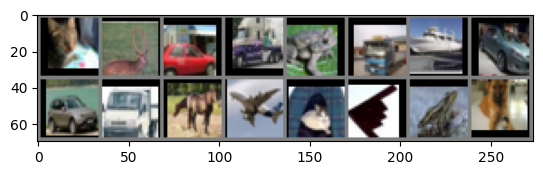

cat -- deer -- car -- truck -- frog -- truck -- ship -- car
car -- truck -- horse -- plane -- cat -- plane -- frog -- dog


In [2]:
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid along with their labels
imshow(torchvision.utils.make_grid(images[:16]))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8)))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8,16)))

## Training on the GPU and Evaluating Performance
Calculate train and test accuracy

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from copy import deepcopy

# Set the random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Define the neural network
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.dropout = nn.Dropout(p=0.5)  # Add dropout layer with 50% dropout rate
        self.bn1 = nn.BatchNorm1d(H)  # Add batch normalization layer
        self.linear2 = torch.nn.Linear(H, D_out)
        self.device = 'cpu'
        self.use_dropout = False  # Flag to control dropout
        self.use_bn = False  # Flag to control batch normalization

        # Initialize weights of self.linear with a small random number from a normal distribution
        #nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
        #nn.init.normal_(self.linear2.weight, mean=0.0, std=0.01)
        nn.init.kaiming_uniform_(self.linear1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.linear2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        #x = x.view(-1, 3*32*32)  # 將x展平以匹配全連接層的期望輸入形狀
        #h_relu = self.linear1(x).clamp(min=0)
        #y_pred = self.linear2(h_relu)
        #return y_pred
        x = x.view(-1, 3*32*32)  # Flatten input to match the input shape expected by the fully connected layer
        h = self.linear1(x)
        if self.use_dropout:
            h = self.dropout(h)  # Apply dropout if flag is set
        if self.use_bn:
            h = self.bn1(h)  # Apply batch normalization if flag is set
        h_relu = h.clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred
    
    def to(self, device):
        self.device = device  # Set the device attribute
        super().to(device)    # Call the parent class' to method    
    
    def evaluate_model(self, data_loader, criterion):
        # let's evaluate its performance on the test dataset.
        self.eval()
        # Test the neural network
        correct = 0
        total = 0
        total_loss = 0.0

        # Disable gradient calculation
        with torch.no_grad():
            for inputs, labels in data_loader:
                #print(inputs.size(), labels.size())

                # Move the inputs and labels to the GPU if available
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # Forward pass
                outputs = self(inputs)

                # Calculate test loss
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)  # 将损失累加，考虑到每个批次的大小
                
                # Get the predicted class
                _, predicted = torch.max(outputs.data, 1)

                # Update the total number of samples and correct predictions
                total += labels.size(0) 
                correct += (predicted == labels).sum().item()

        # 计算平均测试损失
        avg_loss = total_loss / len(data_loader.dataset)
        # Calculate the accuracy
        avg_accuracy = 100 * correct / total
        return avg_loss, avg_accuracy

In [4]:
def reset_and_initialize():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    net = TwoLayerNet(3*32*32, 10, 10)
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)#weight_decay=L2λ 添加一个与权重大小相关的L2项来抑制过拟合，影响梯度更新。
    return net, optimizer, device

In [5]:
def prune_node(model, node_index):
    pruned_model = deepcopy(model)
    old_weights = deepcopy(pruned_model.linear1.weight.data)
    old_biases = deepcopy(pruned_model.linear1.bias.data)
    
    if old_weights.size(0) > 1:
        new_weights = torch.cat((old_weights[:node_index], old_weights[node_index+1:]), 0)
        new_biases = torch.cat((old_biases[:node_index], old_biases[node_index+1:]), 0)
    
        # 更新 pruned_model 的 linear1 层
        pruned_model.linear1 = nn.Linear(old_weights.size(1), new_weights.size(0))    
        pruned_model.linear1.weight.data = new_weights
        pruned_model.linear1.bias.data = new_biases

        # Prune linear2
        old_weights_2 = deepcopy(pruned_model.linear2.weight.data)
        if old_weights_2.size(0) > 1:
            new_weights_2 = torch.cat((old_weights_2[:, :node_index], old_weights_2[:, node_index+1:]), 1)
            # 更新 pruned_model 的 linear2 层
            pruned_model.linear2 = nn.Linear(new_weights_2.size(1), pruned_model.linear2.out_features) #新的 linear2 層，其輸入大小為新的隱藏層大小（即 new_weights_2 的列數），輸出大小保持不變（model.linear2.out_features）
            pruned_model.linear2.weight.data = new_weights_2
            pruned_model.linear2.bias.data = deepcopy(pruned_model.linear2.bias.data)
    else:
        print("Cannot prune all nodes. At least one node must remain.")
    return pruned_model

### EB

In [6]:
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb = []
trn_acc_eb = []
val_loss_eb = []
val_acc_eb = []

# Train the neural network
max_epoch = 10

for epoch_eb in range(max_epoch):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()# Zero the gradients
        outputs = net(inputs)# Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb.append(avg_train_loss)
    trn_acc_eb.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    val_loss_eb.append(avg_test_loss)
    val_acc_eb.append(test_accuracy)
    print(f"Epoch: {epoch_eb + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")


Using device: cpu
Epoch: 1, TrainLoss: 2.0994, TrainAccuracy: 23.34%, TestLoss: 2.0472, TestAccuracy: 28.11%
Epoch: 2, TrainLoss: 1.9364, TrainAccuracy: 29.54%, TestLoss: 1.8471, TestAccuracy: 34.46%
Epoch: 3, TrainLoss: 1.8522, TrainAccuracy: 33.08%, TestLoss: 1.7589, TestAccuracy: 37.02%
Epoch: 4, TrainLoss: 1.8244, TrainAccuracy: 33.93%, TestLoss: 1.7570, TestAccuracy: 36.66%
Epoch: 5, TrainLoss: 1.8074, TrainAccuracy: 34.69%, TestLoss: 1.7522, TestAccuracy: 36.85%
Epoch: 6, TrainLoss: 1.7980, TrainAccuracy: 35.04%, TestLoss: 1.7491, TestAccuracy: 37.09%
Epoch: 7, TrainLoss: 1.7810, TrainAccuracy: 35.82%, TestLoss: 1.7271, TestAccuracy: 38.40%
Epoch: 8, TrainLoss: 1.7772, TrainAccuracy: 36.12%, TestLoss: 1.7058, TestAccuracy: 38.44%
Epoch: 9, TrainLoss: 1.7727, TrainAccuracy: 36.31%, TestLoss: 1.7265, TestAccuracy: 37.85%
Epoch: 10, TrainLoss: 1.7658, TrainAccuracy: 36.48%, TestLoss: 1.7246, TestAccuracy: 37.60%


### EB_irrelevant node pruning

In [7]:
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb_np_irr = []
trn_acc_eb_np_irr = []
val_loss_eb_np_irr = []
val_acc_eb_np_irr = []

# Train the neural network
max_epoch = 10

for epoch_eb_np_irr in range(max_epoch):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()# Zero the gradients
        outputs = net(inputs)# Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb_np_irr.append(avg_train_loss)
    trn_acc_eb_np_irr.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    val_loss_eb_np_irr.append(avg_test_loss)
    val_acc_eb_np_irr.append(test_accuracy)
    print(f"Epoch: {epoch_eb_np_irr + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    print('Weight-tuning block completes.')

    epsilon = 2
    hidden_size = net.linear1.weight.data.size(0)
    #print(f"Initial hidden size: {hidden_size}")
    k = 0 #prunenode_function node_index從0開始
    while k < hidden_size:
        original_net = deepcopy(net)
        #print(original_net)
        kpruned_net = prune_node(net, k)
        #print(kpruned_net)
        kpruned_net.train()    
        kpruned_optimizer = optim.Adam(kpruned_net.parameters(), lr=0.001, weight_decay=0.001)

        kpruned_running_loss = 0.0
        kpruned_train_correct = 0
        kpruned_train_total = 0

        for j, (inputs, labels) in enumerate(train_loader, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)
            kpruned_optimizer.zero_grad()
            outputs = kpruned_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            kpruned_optimizer.step()
            kpruned_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

        kpruned_avg_train_loss = kpruned_running_loss / (j + 1)

        if kpruned_avg_train_loss < epsilon:
            hidden_size -= 1
            net = deepcopy(kpruned_net)
            optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
            print(f"{k}th Node pruned and {kpruned_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss} < epsilon {epsilon}")
        else:
            net = original_net
            print(f"{k}th Node retained and {original_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss} >= epsilon {epsilon}")
            k += 1
    print('Node-pruning block completes.')

Using device: cpu
Epoch: 1, TrainLoss: 2.1158, TrainAccuracy: 22.79%, TestLoss: 1.9806, TestAccuracy: 31.14%
Weight-tuning block completes.
0th Node pruned and 9 remained as train loss of the pruned network 1.9652948312442322 < epsilon 2
0th Node pruned and 8 remained as train loss of the pruned network 1.9387216439942265 < epsilon 2
0th Node pruned and 7 remained as train loss of the pruned network 1.8952926664096315 < epsilon 2
0th Node pruned and 6 remained as train loss of the pruned network 1.9012587122295215 < epsilon 2
0th Node pruned and 5 remained as train loss of the pruned network 1.9237891054519303 < epsilon 2
0th Node pruned and 4 remained as train loss of the pruned network 1.9510060268289902 < epsilon 2
0th Node retained and 4 remained as train loss of the pruned network 2.031617806848053 >= epsilon 2
1th Node retained and 4 remained as train loss of the pruned network 2.021056625544263 >= epsilon 2
2th Node retained and 4 remained as train loss of the pruned network 2.0

### EB_potentially irrelevant node pruning

In [8]:
import numpy as np

# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb_np_pirr = []
trn_acc_eb_np_pirr = []
val_loss_eb_np_pirr = []
val_acc_eb_np_pirr = []

# Train the neural network
max_epoch = 10

for epoch_eb_np_pirr in range(max_epoch):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()# Zero the gradients
        outputs = net(inputs)# Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb_np_pirr.append(avg_train_loss)
    trn_acc_eb_np_pirr.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    val_loss_eb_np_pirr.append(avg_test_loss)
    val_acc_eb_np_pirr.append(test_accuracy)
    print(f"Epoch: {epoch_eb_np_pirr + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    print('Weight-tuning block completes.')

    epsilon = 2
    hidden_size = net.linear1.weight.data.size(0)
    #print(f"Initial hidden size: {hidden_size}")
    k = 0 #prunenode_function node_index從0開始
    max_epoch_np = 2
    while k < hidden_size:
        original_net = deepcopy(net)
        #print(original_net)
        kpruned_net = prune_node(net, k)
        #print(kpruned_net)
        kpruned_avg_train_loss_list = []
        for epoch_np in range(max_epoch_np): 
            kpruned_net.train()    
            kpruned_optimizer = optim.Adam(kpruned_net.parameters(), lr=0.001, weight_decay=0.001)

            kpruned_running_loss = 0.0

            for j, (inputs, labels) in enumerate(train_loader, 0):
                inputs = inputs.to(device)
                labels = labels.to(device)
                kpruned_optimizer.zero_grad()
                outputs = kpruned_net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                kpruned_optimizer.step()
                kpruned_running_loss += loss.item()
            # 訓練損失: 782個mini-batch loss的平均值
            kpruned_avg_train_loss = kpruned_running_loss / (j + 1)
            kpruned_avg_train_loss_list.append(kpruned_avg_train_loss)
        kpruned_avg_train_loss_mean = np.mean(kpruned_avg_train_loss)
        if kpruned_avg_train_loss_mean < epsilon:
            hidden_size -= 1
            net = deepcopy(kpruned_net)
            optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
            print(f"{k}th Node pruned and {kpruned_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss_mean} < epsilon {epsilon}")
        else:
            net = original_net
            print(f"{k}th Node retained and {original_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss_mean} >= epsilon {epsilon}")
            k += 1
    print('Node-pruning block completes.')

Using device: cpu
Epoch: 1, TrainLoss: 2.1160, TrainAccuracy: 23.85%, TestLoss: 2.0749, TestAccuracy: 32.29%
Weight-tuning block completes.
0th Node pruned and 9 remained as train loss of the pruned network 1.893775506854972 < epsilon 2
0th Node pruned and 8 remained as train loss of the pruned network 1.8418444538360361 < epsilon 2
0th Node pruned and 7 remained as train loss of the pruned network 1.84124796957616 < epsilon 2
0th Node pruned and 6 remained as train loss of the pruned network 1.8819919850515283 < epsilon 2
0th Node pruned and 5 remained as train loss of the pruned network 1.9147678406342217 < epsilon 2
0th Node pruned and 4 remained as train loss of the pruned network 1.9531294349819193 < epsilon 2
0th Node pruned and 3 remained as train loss of the pruned network 1.984170744181289 < epsilon 2
0th Node retained and 3 remained as train loss of the pruned network 2.02903988949783 >= epsilon 2
1th Node retained and 3 remained as train loss of the pruned network 2.03044018

### EB_random node pruning

In [9]:
import random
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb_np_rand = []
trn_acc_eb_np_rand = []
val_loss_eb_np_rand = []
val_acc_eb_np_rand = []

# Train the neural network
max_epoch = 10

for epoch_eb_np_rand in range(max_epoch):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()# Zero the gradients
        outputs = net(inputs)# Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb_np_rand.append(avg_train_loss)
    trn_acc_eb_np_rand.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    val_loss_eb_np_rand.append(avg_test_loss)
    val_acc_eb_np_rand.append(test_accuracy)
    print(f"Epoch: {epoch_eb_np_rand + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    print('Weight-tuning block completes.')

    fail = 0
    epsilon = 2
    hidden_size = net.linear1.weight.data.size(0)

    max_epoch_np = 2
    while fail < 3:
        original_net = deepcopy(net)
        #print(original_net)
        k = random.randint(0, hidden_size-1)
        kpruned_net = prune_node(net, k)
        #print(kpruned_net)
        kpruned_avg_train_loss_list = []
        for epoch_np in range(max_epoch_np): 
            kpruned_net.train()    
            kpruned_optimizer = optim.Adam(kpruned_net.parameters(), lr=0.001, weight_decay=0.001)

            kpruned_running_loss = 0.0

            for j, (inputs, labels) in enumerate(train_loader, 0):
                inputs = inputs.to(device)
                labels = labels.to(device)
                kpruned_optimizer.zero_grad()
                outputs = kpruned_net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                kpruned_optimizer.step()
                kpruned_running_loss += loss.item()
            # 訓練損失: 782個mini-batch loss的平均值
            kpruned_avg_train_loss = kpruned_running_loss / (j + 1)
            kpruned_avg_train_loss_list.append(kpruned_avg_train_loss)
        print(kpruned_avg_train_loss_list)
        kpruned_avg_train_loss_mean = np.mean(kpruned_avg_train_loss_list)
        if kpruned_avg_train_loss_mean < epsilon:
            hidden_size -= 1
            net = deepcopy(kpruned_net)
            optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
            print(f"{k}th Node pruned and {kpruned_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss_mean} < epsilon {epsilon}")
            fail = 0
        else:
            net = original_net
            print(f"{k}th Node retained and {original_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss_mean} >= epsilon {epsilon}")
            fail += 1
            print(f"failCount:{fail}")
    print('Node-pruning block completes.')

Using device: cpu
Epoch: 1, TrainLoss: 2.0996, TrainAccuracy: 22.37%, TestLoss: 2.0299, TestAccuracy: 26.69%
Weight-tuning block completes.
[2.0285728162206955, 1.9361306110306469]
9th Node pruned and 9 remained as train loss of the pruned network 1.9823517136256712 < epsilon 2
[1.9028469225024933, 1.8517159534537273]
5th Node pruned and 8 remained as train loss of the pruned network 1.8772814379781102 < epsilon 2
[1.8599468021441603, 1.8342400536207897]
2th Node pruned and 7 remained as train loss of the pruned network 1.8470934278824749 < epsilon 2
[1.8814752755872428, 1.868923716075585]
0th Node pruned and 6 remained as train loss of the pruned network 1.875199495831414 < epsilon 2
[1.9188411633681763, 1.897075464048654]
3th Node pruned and 5 remained as train loss of the pruned network 1.907958313708415 < epsilon 2
[1.9399449018871082, 1.927840841243334]
4th Node pruned and 4 remained as train loss of the pruned network 1.933892871565221 < epsilon 2
[1.9699024489468626, 1.958503342

In [10]:
def find_min_weight_node(model):
    # 获取第二层（从隐藏层到输出层）的权重
    weights = model.linear2.weight.data
    #print(weights)
    # 计算每个隐藏节点到输出层的权重的绝对值之和
    weight_sums = weights.abs().sum(dim=0)
    #print(weight_sums)
    # 找到最小权重和的索引
    min_weight_index = torch.argmin(weight_sums).item()
    #print(min_weight_index)
    return min_weight_index

### EB_min weight node pruning

In [11]:
import random
# Example usage
net, optimizer, device = reset_and_initialize()
criterion = nn.CrossEntropyLoss() #分類任務的損失函數

trn_loss_eb_np_mw = []
trn_acc_eb_np_mw = []
val_loss_eb_np_mw = []
val_acc_eb_np_mw = []

# Train the neural network
max_epoch = 10

for epoch_eb_np_mw in range(max_epoch):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()# Zero the gradients
        outputs = net(inputs)# Forward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    train_accuracy = 100 * train_correct / train_total
    trn_loss_eb_np_mw.append(avg_train_loss)
    trn_acc_eb_np_mw.append(train_accuracy)

    # Evaluate on test data after each epoch
    avg_test_loss, test_accuracy = TwoLayerNet.evaluate_model(net, test_loader, criterion)
    val_loss_eb_np_mw.append(avg_test_loss)
    val_acc_eb_np_mw.append(test_accuracy)
    print(f"Epoch: {epoch_eb_np_mw + 1}, TrainLoss: {avg_train_loss:.4f}, TrainAccuracy: {train_accuracy:.2f}%, TestLoss: {avg_test_loss:.4f}, TestAccuracy: {test_accuracy:.2f}%")
    print('Weight-tuning block completes.')

    epsilon = 2
    hidden_size = net.linear1.weight.data.size(0)

    while True:
        original_net = deepcopy(net)
        #print(original_net)
        k = find_min_weight_node(net)
        kpruned_net = prune_node(net, k)
        #print(kpruned_net)
        kpruned_avg_train_loss_list = []
        for epoch_np in range(max_epoch_np): 
            kpruned_net.train()    
            kpruned_optimizer = optim.Adam(kpruned_net.parameters(), lr=0.001, weight_decay=0.001)

            kpruned_running_loss = 0.0

            for j, (inputs, labels) in enumerate(train_loader, 0):
                inputs = inputs.to(device)
                labels = labels.to(device)
                kpruned_optimizer.zero_grad()
                outputs = kpruned_net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                kpruned_optimizer.step()
                kpruned_running_loss += loss.item()
            # 訓練損失: 782個mini-batch loss的平均值
            kpruned_avg_train_loss = kpruned_running_loss / (j + 1)
            kpruned_avg_train_loss_list.append(kpruned_avg_train_loss)
        #print(kpruned_avg_train_loss_list)
        kpruned_avg_train_loss_mean = np.mean(kpruned_avg_train_loss_list)
        if kpruned_avg_train_loss_mean < epsilon:
            hidden_size -= 1
            net = deepcopy(kpruned_net)
            optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
            print(f"{k}th Node pruned and {kpruned_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss_mean} < epsilon {epsilon}")
        else:
            net = original_net
            print(f"{k}th Node retained and {original_net.linear1.weight.data.size(0)} remained as train loss of the pruned network {kpruned_avg_train_loss_mean} >= epsilon {epsilon}")
            break
    print('Node-pruning block completes.')

Using device: cpu
Epoch: 1, TrainLoss: 2.0697, TrainAccuracy: 24.27%, TestLoss: 1.9871, TestAccuracy: 30.32%
Weight-tuning block completes.
0th Node pruned and 9 remained as train loss of the pruned network 1.9181695310660944 < epsilon 2
4th Node pruned and 8 remained as train loss of the pruned network 1.855348752130328 < epsilon 2
1th Node pruned and 7 remained as train loss of the pruned network 1.839617233065998 < epsilon 2
4th Node pruned and 6 remained as train loss of the pruned network 1.881836254654638 < epsilon 2
3th Node pruned and 5 remained as train loss of the pruned network 1.9143640321996207 < epsilon 2
2th Node pruned and 4 remained as train loss of the pruned network 1.938402817301128 < epsilon 2
0th Node pruned and 3 remained as train loss of the pruned network 1.9878567150791588 < epsilon 2
2th Node retained and 3 remained as train loss of the pruned network 2.044020775105337 >= epsilon 2
Node-pruning block completes.
Epoch: 2, TrainLoss: 1.9614, TrainAccuracy: 27.9

## Visualizing performance

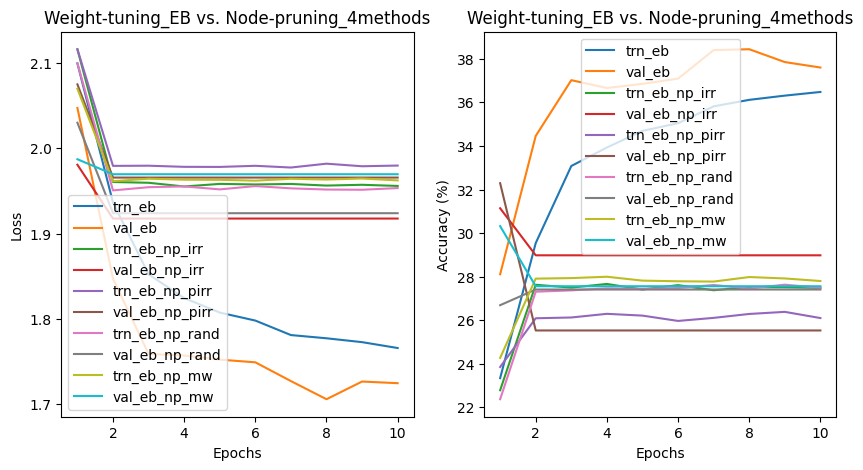

In [14]:
from matplotlib import pyplot as plt

# 繪製loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(range(1, epoch_eb+2), trn_loss_eb, label='trn_eb')
plt.plot(range(1, epoch_eb+2), val_loss_eb, label='val_eb')

plt.plot(range(1, epoch_eb_np_irr+2), trn_loss_eb_np_irr, label='trn_eb_np_irr')
plt.plot(range(1, epoch_eb_np_irr+2), val_loss_eb_np_irr, label='val_eb_np_irr')

plt.plot(range(1, epoch_eb_np_pirr+2), trn_loss_eb_np_pirr, label='trn_eb_np_pirr')
plt.plot(range(1, epoch_eb_np_pirr+2), val_loss_eb_np_pirr, label='val_eb_np_pirr')

plt.plot(range(1, epoch_eb_np_rand+2), trn_loss_eb_np_rand, label='trn_eb_np_rand')
plt.plot(range(1, epoch_eb_np_rand+2), val_loss_eb_np_rand, label='val_eb_np_rand')

plt.plot(range(1, epoch_eb_np_mw+2), trn_loss_eb_np_mw, label='trn_eb_np_mw')
plt.plot(range(1, epoch_eb_np_mw+2), val_loss_eb_np_mw, label='val_eb_np_mw')

plt.title('Weight-tuning_EB vs. Node-pruning_4methods')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 繪製accuracy
#plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)

plt.plot(range(1, epoch_eb+2), trn_acc_eb, label='trn_eb')
plt.plot(range(1, epoch_eb+2), val_acc_eb, label='val_eb')

plt.plot(range(1, epoch_eb_np_irr+2), trn_acc_eb_np_irr, label='trn_eb_np_irr')
plt.plot(range(1, epoch_eb_np_irr+2), val_acc_eb_np_irr, label='val_eb_np_irr')

plt.plot(range(1, epoch_eb_np_pirr+2), trn_acc_eb_np_pirr, label='trn_eb_np_pirr')
plt.plot(range(1, epoch_eb_np_pirr+2), val_acc_eb_np_pirr, label='val_eb_np_pirr')

plt.plot(range(1, epoch_eb_np_rand+2), trn_acc_eb_np_rand, label='trn_eb_np_rand')
plt.plot(range(1, epoch_eb_np_rand+2), val_acc_eb_np_rand, label='val_eb_np_rand')

plt.plot(range(1, epoch_eb_np_mw+2), trn_acc_eb_np_mw, label='trn_eb_np_mw')
plt.plot(range(1, epoch_eb_np_mw+2), val_acc_eb_np_mw, label='val_eb_np_mw')

plt.title('Weight-tuning_EB vs. Node-pruning_4methods')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()